In [1]:
# work in progress

In [2]:
# TODO

# - in total we need 60 min / 5 min = 12 seeds (3 skin areas á 4 heat pain applications)
# - estimate number of resulting data for neural network training

In [3]:
import sys
from pathlib import Path
PROJECT_DIR = Path.cwd()
if PROJECT_DIR.stem == 'notebooks':
    PROJECT_DIR = PROJECT_DIR.parent
    sys.path.insert(0, '..')
    %load_ext autoreload
    %autoreload 2

In [4]:
from src.experiments.stimuli_function import StimuliFunction, stimuli_extra
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets 


In [5]:
minimal_desired_duration = 200 # in seconds
periods = [67*2, 20] # [0] is the baseline and [1] the modulation; in seconds
frequencies = 1./np.array(periods)
amplitudes = [1, 1.5] # temp range is 2 * sum(amplitudes): max @ VAS 70, min @ VAS 0
sample_rate = 10
seed = None #823 # use None for random seed
baseline_temp = 39.2 # @ VAS 35

In [6]:
def vanilla_stimuli(
        baseline_period, modulation_period,
        baseline_amplitude, modulation_amplitude, 
        plot_baseline=False, plot_modulation=False,
        random_periods=False):
    periods = [baseline_period, modulation_period]
    frequencies = 1./np.array(periods)
    amplitudes = [baseline_amplitude, modulation_amplitude]
    vanilla = StimuliFunction(
        minimal_desired_duration,
        frequencies,
        amplitudes,
        sample_rate=sample_rate,
        random_periods=random_periods)
    plt.plot(vanilla.wave, label="wave")
    if plot_baseline:
        plt.plot(vanilla.baseline, label="baseline", linestyle="-.", color="grey")
    if plot_modulation:
        plt.plot(vanilla.modulation, label="modulation", linestyle="--", color="grey")
    plt.xlabel('Time (s/10)')
    plt.ylabel('Temperature - Baseline (°C)')
    plt.ylim([-sum(amplitudes)-0.1, sum(amplitudes)+0.1])
    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)

modulation_period_widget = widgets.IntSlider(min=10, max=40, step=1, value=20, description="Period Mod.")
baseline_period_widget = widgets.IntSlider(min=40, max=200, step=1, value=134, description="Period Base.")
baseline_amplitude_widget = widgets.FloatSlider(min=0, max=5, step=0.25, value=1, description="Ampli. Base.")
modulation_amplitude_widget = widgets.FloatSlider(min=0, max=5, step=0.25, value=1.5, description="Ampli. Mod.")

widget = widgets.interact(
    vanilla_stimuli,
    baseline_period=baseline_period_widget, 
    modulation_period=modulation_period_widget, 
    baseline_amplitude=baseline_amplitude_widget,
    modulation_amplitude=modulation_amplitude_widget, 
    plot_baseline=False,
    plot_modulation=False,
    random_periods=False
)

interactive(children=(IntSlider(value=134, description='Period Base.', max=200, min=40), IntSlider(value=20, d…

In [7]:
stimuli = StimuliFunction(
    minimal_desired_duration,
    frequencies,
    amplitudes,
    sample_rate,
    random_periods=True,
    seed=seed
).add_baseline_temp(
    baseline_temp
).add_plateaus(
    plateau_duration=20, 
    n_plateaus=4, 
    add_at_start="random", 
    add_at_end=True)
print(f"Seed: {stimuli.seed}")
_ = stimuli_extra(stimuli.wave, stimuli.wave_dot, stimuli.sample_rate, s_RoC=0.2, display_stats=True)

Seed: 331


Cooling segments [s] based on 'Label_alt' with a rate of change threshold of 0.2 (°C/s):

count    7.00
mean     4.06
std      0.60
min      3.50
25%      3.60
50%      3.80
75%      4.40
max      5.10
dtype: object


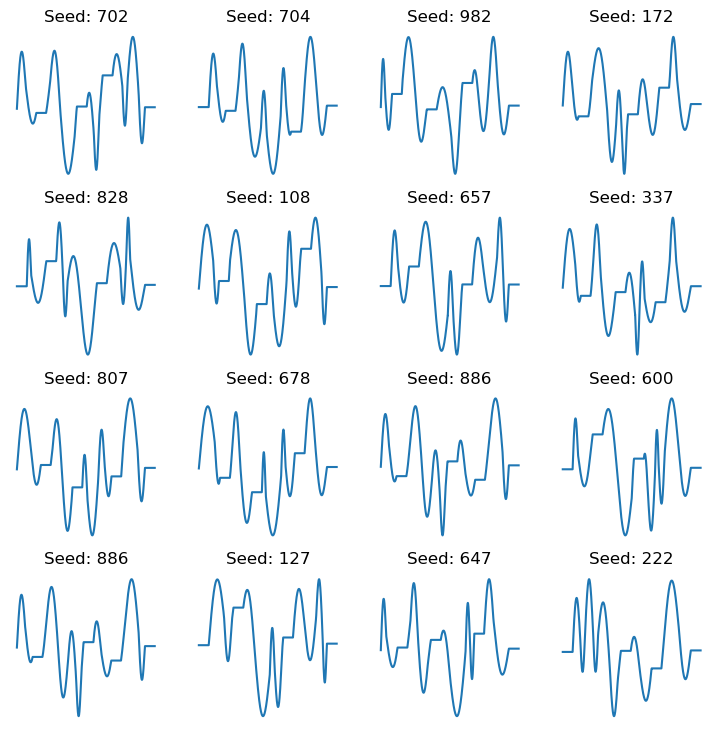

In [8]:
# Plot stimuli
rows, cols = 4, 4
fig, axes = plt.subplots(rows, cols, figsize=(9, 9), dpi=100)
random_seeds = np.random.randint(0, 1000, rows*cols)

for ax, random_seed in zip(axes.flat, random_seeds):
    stimuli = StimuliFunction(
        minimal_desired_duration,
        frequencies,
        amplitudes,
        sample_rate,
        random_periods=True,
        seed=random_seed
    ).add_plateaus(
        plateau_duration=20, 
        n_plateaus=4, 
        add_at_start="random", 
        add_at_end=True
    ).wave
    ax.plot(stimuli)
    ax.set_title(f"Seed: {random_seed}")
    ax.axis(False)